In [1]:
import numpy as np
import pandas as pd
import math
from itertools import count
from tqdm.auto import tqdm
import threading
import os, platform
import multiprocessing
import subprocess
from queue import Empty as QueueEmpty
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from matplotlib import rc
rc('text',usetex=True)
rc('text.latex', preamble='\\usepackage{color}')

In [7]:
# model_list_name, output_dir = 'models_random_5_15_s5', 'results_random_5_15_s5'
# model_list_name, output_dir = 'models_random_6_20_s5', 'results_random_6_20_s5'
# model_list_name, output_dir = 'models_random_6_15', 'results_random_6_15'
# model_list_name, output_dir = 'models_random_5_12', 'results_random_5_12'
# model_list_name, output_dir = 'models_mcc200', 'results_mcc200'
model_list_name, output_dir = 'models_mcc2', 'results_mcc2'
# model_list_name, output_dir = 'models_mcc200quick', 'results_mcc200quick'
# model_list_name, output_dir = 'models_random', 'results_random'
max_time = 5 # 5
n_parallel = 4 # 8
run_all = False # run all tests or only those that don't have the .log file

In [8]:
# Load models and benchmark definition
model_list = open(model_list_name+'.txt', 'r').readlines()
model_list = [ f.replace('\n', '') for f in model_list ]
model_list = [ f for f in model_list if len(f) > 0 ]
# model_list = model_list[:10]
print(len(model_list))
os.makedirs(output_dir, exist_ok=True)

392


In [9]:
def run_commands(queue, pin, pbar):
    while True:
        try:
            qe = queue.get()#block=False)
            if qe is None:
                break
            # print(qe)
            tool, test_name, args, model_fname = qe
            model_basename = model_fname.split('/')[-1]
            logfile = f'{output_dir}/{model_basename}-{test_name}.log'
            os.remove(logfile) if os.path.exists(logfile) else None
            if run_all or not os.path.exists(logfile):
                # print(logfile)
                with open(logfile, 'w') as f:
                    print('****************', file=f)
                    print(f'MODEL={model_fname}\n', file=f)
                    f.flush()
                    if platform.system()=='Darwin':
                        cmd = f'gtimeout {max_time}s '
                    else:
                        cmd = f'/usr/bin/time --verbose /usr/bin/timeout {max_time}s taskset -c {2*pin} ' 
                    # cmd = ''
                    if tool=='sym':
                        cmd += f'../build/sym_hilbert -c -p -u {model_fname} {args} '
                    elif tool=='4ti2':
                        cmd += f'{args} {model_fname} '
                
                    try:
                        proc = subprocess.run(cmd, shell=True, stdout=f, stderr=f)
                        exitcode = proc.returncode
                    except subprocess.TimeoutExpired:
                        exitcode = 124  # timeout

                # append exit status to the log file
                with open(logfile, 'a') as f:
                    print(f'\nEXITCODE={exitcode}\n', file=f)

                if exitcode not in [0,124]:
                    print(qe, f'EXITCODE={exitcode}')
            pbar.update(1)
        except QueueEmpty:
            print('queue empty')
            break # no more commands
    # print(f'Thread {pin} ends.')

In [10]:
tests = [
    # # [ "sym",  'TestKerA',    '' ],
    # ######### Hilbert basis #########
    # [ "4ti2", "Hil_4ti2",  "/home/elvio/4ti2/src/zsolve/hilbert" ],
    # [ "sym",  'Hil_Ga',    '-ye -nl' ],
    # [ "sym",  'Hil_GL',    '-ye -yl' ],
    # [ "sym",  'Hil_na',    '-ne -nl' ],
    # [ "sym",  'Hil_nL',    '-ne -yl' ],
    # [ "sym",  'Hil_nLH',    '-ne -yl -hg' ],
    # [ "sym",  'Hil_LD',    '-ne -yl -yd' ],
    # # [ "sym",  'Hil_nP',    '-ne -yl -po' ],
    # [ "sym",  'Hil_LS',    '-ne -yl -s' ],
    # # [ "sym",  'Hil_LZ',    '-ne -yl -z' ],
    # # [ "sym",  'Hil_LZD',   '-ne -yl -z -yd' ],
    # # [ "sym",  'Hil_LZS',   '-ne -yl -z -yd -s' ],
    # [ "sym",  'Hil_HNF',   '-ne -yl -yd -np' ],
    # [ "sym",  'Hil_IGE',   '-ne -yl -yd -np -ige' ],

    # ######### Extreme Rays #########
    # # [ "4ti2", "Ray_4ti2",  "/home/elvio/4ti2/src/groebner/rays" ],
    # [ "sym",  'Ray_nL',    '-ne -yl -x' ],
    # # [ "sym",  'Ray_LZ',    '-ne -yl -z -x' ],
    # # [ "sym",  'Ray_LD',    '-ne -yl -d -x' ],
    # # [ "sym",  'Ray_LZD',   '-ne -yl -z -yd -x' ],
    # # [ "sym",  'Ray_LS',    '-ne -yl -s -x' ],
    # # # [ "sym",  'Ray_LZS',   '-ne -yl -z -s -x' ],
    # # # [ "sym",  'Ray_nP',    '-ne -yl -po -x' ],

    # ######### Graver basis #########
    [ "4ti2", "Gra_4ti2",  "/home/elvio/4ti2/src/zsolve/graver" ], 
    # [ "4ti2", "Gra_4ti2",  "time graver" ], # "/home/elvio/4ti2/src/zsolve/graver"
    # [ "sym",  'Gra_Ga',    '-ye -nl -g' ],
    [ "sym",  'Gra_pottier',   '-g -nl' ],
    [ "sym",  'Gra_PnL',       '-g -yl' ],
    # [ "sym",  'Gra_nG',    '-yeg -nl -g -po' ],
    [ "sym",  'Gra_degree',    '-g -s -ps' ],
    # [ "sym",  'Gra_nLH',    '-ne -yl -g -hg' ],
    # # # [ "sym",  'Gra_nP',    '-ne -yl -po -g' ],



    # [ "sym",  'Gra_degree',    '-g -s -ps' ],
    # [ "sym",  'Ray_degree',    '-x -s -ps' ], # deactivated
    # [ "sym",  'Hil_degree',    '   -s -ps' ],

    # [ "sym",  'Hil_pottier',    '-nl' ],
    # [ "sym",  'Hil_PnL',    '-yl' ],

    # [ "sym",  'Ray_pottier',   '-x -nl' ],
    # [ "sym",  'Ray_PnL',       '-x -yl' ],
    # [ "sym",  'Ray_degree',    '-x -yl -s' ],
]
# generate commands
queue = multiprocessing.Queue(maxsize=10000)
num_runs = 0
for tool, test_name, args in tests:
    for model in model_list:
        queue.put([tool,  test_name, args, model])
        num_runs += 1
print('num_runs=',num_runs)
for i in range(n_parallel):
    queue.put(None)

num_runs= 1568


In [11]:
with tqdm(total=num_runs) as pbar:
    # run the commands in parallel
    threads = []
    for i in range(n_parallel):
        threads.append(threading.Thread(target=run_commands, args=(queue, i, pbar)))
        
    for t in threads: # start all threads
        t.start()
    for t in threads: # wait for all terminations
        t.join()
queue.close()
print('Done')

  0%|          | 0/1568 [00:00<?, ?it/s]

Done


In [12]:
data = []
for model_fname in model_list:
    model_basename = model_fname.split('/')[-1]
    row = {'model':model_basename}
    row['mdd_nodes'] = row['mdd_edges'] = None
    for tool, test_name, args in tests:
        logfile = f'{output_dir}/{model_basename}-{test_name}.log'
        if os.path.exists(logfile):
            tm = None
            cntC = None
            with open(logfile) as f:
                for line in f:
                    line = line.strip()
                    if line.startswith('User time'):
                        tm = float(line.split(':')[1])
                    elif line.startswith('CPU usage'):
                        tm = float(line.split(':')[1])
                    elif 'user' in line and 'sys' in line:
                        tm = float(line.split()[2])
                    elif line.startswith('Total S-Vectors processed') or line.startswith('_completes:') or line.startswith('Added:'):
                        # print(line, float(line.split(':')[1]))
                        cntC = int(float(line.split(':')[1]))
                    elif line.startswith('EXITCODE'):
                        # ec = int(re.sub(' +', ' ', line).split(' ')[1])
                        ec = int(line.split('=')[1])
                        if ec==124:
                            tm = None
                        elif ec != 0:
                            print(line, logfile)
                    elif line.startswith('Z-Generators:'):
                        row['num_Zgens'] = int(line.split(':')[1])
                    elif line.startswith('Basis:'):
                        row['out_sz'] = float(line.split(':')[1])
                    elif line.startswith('Variables:'):
                        row['num_vars'] = int(line.split(':')[1])
                    elif line.startswith('Basis MDD Nodes:'):
                        row['mdd_nodes'] = int(line.split(':')[1])
                    elif line.startswith('Basis MDD Edges:'):
                        row['mdd_edges'] = int(line.split(':')[1])
            row[test_name] = tm
            row[test_name+'_C'] = cntC
    data.append(row)
data = pd.DataFrame(data)
data.to_csv(f'data_{model_list_name}.csv', index=False)
print(f'data_{model_list_name}.csv')

data_models_mcc2.csv


In [13]:
data.head(10)

,model,mdd_nodes,mdd_edges,Gra_4ti2,Gra_4ti2_C,num_Zgens,num_vars,Gra_pottier,Gra_pottier_C,Gra_PnL,Gra_PnL_C,Gra_degree,Gra_degree_C,out_sz
0,Sudoku-PT-AN06,NaN,NaN,NaN,NaN,108,324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referendum-PT-0010,402.0,442.0,0.01,87.0,10,31,0.01,1.000000e+02,0.03,4.500000e+01,0.02,4.500000e+01,5.500000e+01
2,ProductionCell-PT-none,NaN,NaN,NaN,NaN,50,176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DiscoveryGPU-PT-09b,13312.0,13377.0,0.16,14976.0,11,268,0.92,1.111000e+03,3.18,9.550000e+02,1.91,5.500000e+01,6.600000e+01
4,ShieldRVt-PT-002A,86.0,105.0,0.00,53.0,9,19,0.00,8.100000e+01,0.00,3.600000e+01,0.00,3.600000e+01,4.500000e+01
5,DNAwalker-PT-07track28RR,0.0,0.0,0.01,0.0,0,34,0.00,0.000000e+00,0.01,0.000000e+00,0.01,0.000000e+00,0.000000e+00
6,Solitaire-PT-EngCT7x7,430.0,544.0,NaN,NaN,34,67,1.36,3.242790e+16,0.06,1.073740e+10,0.08,8.589930e+09,8.589930e+09
7,Sudoku-PT-AN01,10.0,15.0,0.00,10.0,3,4,0.00,9.000000e+00,0.00,3.000000e+00,0.00,3.000000e+00,6.000000e+00
8,ShieldPPPs-PT-005B,NaN,NaN,0.73,22258.0,56,343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,TriangularGrid-PT-3011,1606.0,1974.0,NaN,NaN,46,108,NaN,NaN,0.23,5.277660e+13,0.57,3.518440e+13,3.518440e+13


In [14]:
# # from decimal import Decimal
# data = pd.read_csv(f'data_{output_dir}.csv')
# for c in data.columns:
#     if c.endswith('_C'):
#         data[c] = pd.to_numeric(data[c])#.astype(Decimal)
#     if c.startswith('Hil_'):
#         data[c] = data[c].astype(float)

## Plot

In [15]:
# plot_list_name = 'models_random_5_15_s5'
# plot_list_name = 'models_random_6_20_s5'
# plot_list_name = 'models_random_6_15'
# plot_list_name = 'models_random'
# plot_list_name = 'models_mcc200'
plot_list_name = 'models_mcc2'
data = pd.read_csv(f'data_{plot_list_name}.csv')
data.head(3)

,model,mdd_nodes,mdd_edges,Gra_4ti2,Gra_4ti2_C,num_Zgens,num_vars,Gra_pottier,Gra_pottier_C,Gra_PnL,Gra_PnL_C,Gra_degree,Gra_degree_C,out_sz
0,Sudoku-PT-AN06,NaN,NaN,NaN,NaN,108,324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referendum-PT-0010,402.0,442.0,0.01,87.0,10,31,0.01,100.0,0.03,45.0,0.02,45.0,55.0
2,ProductionCell-PT-none,NaN,NaN,NaN,NaN,50,176,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
name_map = { 'Ga':'G*', 'na':'**', 'nL':'*L', 'nP':'*P', 'LD':'*LD', 'LS':'*LS', 
             'LZ':'*LZ', 'LZD':'*LZD', 'LZS':'*LZS', 'LZS2':'*LZS2', '4ti2':'4ti2',
             'pottier':'Pottier', 'PnL':'Project\&Lift', 'degree':'Graded' }
order_map = { '4ti2':100, 'pottier':0, 'PnL':1, 'degree':2 }

In [17]:
col_names = sorted([c for c in data.columns if '_' in c and not c.endswith('_C') ], reverse=True)

['Gra_pottier', 'Gra_PnL', 'Gra_degree', 'Gra_4ti2'] ['Gra_4ti2', 'Gra_PnL', 'Gra_degree', 'Gra_pottier']


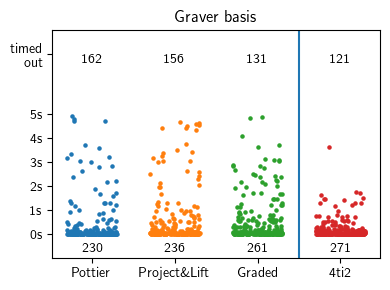

In [18]:
def remap(s): 
    return name_map[s] if s in name_map else s
# vecs = [np.array(new_list[c]) for c in col_names]
fig,axes = plt.subplots(1,1, figsize=(4, 3))
# fig,axes = plt.subplots(1,3, figsize=(12, 3), width_ratios=[4,3,2])
y_tout = 7
xx = (np.random.rand(len(data)) - 0.5) * 0.6
yy = np.random.rand(len(data)) + y_tout
for jj in [2]:#range(3):
    prefix = {0:('Hil', 'Hilbert basis'), 1:('Ray', 'Extremal rays'), 2:('Gra', 'Graver basis')}
    ax = axes
    jj_col_names = [c for c in col_names if c.startswith(prefix[jj][0])]
    jj_col_names = [(order_map[c.split('_')[1]], c) for c in jj_col_names]
    jj_col_names = [c for _,c in sorted(jj_col_names)]
    print(jj_col_names, sorted(jj_col_names))
    for i, col_name in enumerate(jj_col_names):
        vv = np.array(data[col_name])
        filter_tout = np.logical_not(np.isnan(vv))
        num_tout = np.sum(np.logical_not(filter_tout))
        # vv[vv<0] = yy[vv<0]
        ax.scatter(xx[filter_tout]+i, vv[filter_tout], s=5)
        ax.text(i, y_tout, f'{num_tout}', fontsize=10, ha='center', va='bottom')
        ax.text(i, -.75, f'{len(vv)-num_tout}', fontsize=10, ha='center')
    ax.set_title(prefix[jj][1])
    
    ax.set_xticks(range(len(jj_col_names)), [remap(c.split('_')[1]) for c in jj_col_names])
    ax.set_yticks(list(range(6))+[y_tout+.5], [f'{s}s' for s in list(range(6))]+['timed\nout'])
    ax.vlines(i-.5, -1, y_tout+2) 
    ax.set_ylim(-1, y_tout+1.5)
plt.tight_layout()
plt.savefig(f'{plot_list_name}-time.pdf', bbox_inches='tight')
plt.show()

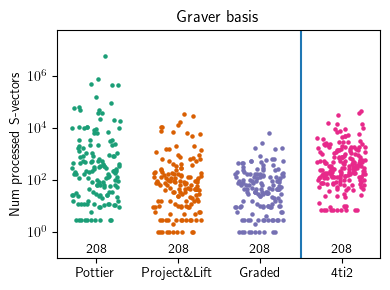

In [19]:
from matplotlib  import colormaps
cmap = colormaps['Dark2']
fig,axes = plt.subplots(1,1, figsize=(4, 3))
# fig,axes = plt.subplots(1,3, figsize=(12, 3), width_ratios=[4,3,2])
for jj in [2]: #range(3):
#     if jj==1: continue
    prefix = {0:('Hil', 'Hilbert basis'), 1:('Ray', 'Extremal rays'), 2:('Gra', 'Graver basis')}
    ax = axes
    jj_col_names = [c for c in col_names if c.startswith(prefix[jj][0])]# and not '4ti2' in c]
    jj_col_names = [(order_map[c.split('_')[1]], c) for c in jj_col_names]
    jj_col_names = [c for _,c in sorted(jj_col_names)]
    NL = data.copy()
    y_tout = 1
    for n in jj_col_names:
        # NL = NL[ NL[n+'_C'] != -1 ]
        NL = NL[ np.logical_not(np.isnan(NL[n+'_C'])) ]
    for n in jj_col_names:
        vmax = NL[n+'_C'].max()
        y_tout = max(y_tout, 1 if np.isnan(vmax) else vmax)
    y_tout *= 10
    xx = (np.random.rand(len(NL)) - 0.5) * 0.6
    yy = np.random.rand(len(NL)) + y_tout
    for i, col_name in enumerate(jj_col_names):
        vv = np.array(NL[col_name])
        vC = np.array(NL[col_name+'_C'], dtype=int)
        tout_mask = vv<0
        num_tout = np.sum(tout_mask)
#         y_tout = 1e+15
        vC[tout_mask] = yy[tout_mask]
        vC[vC < 0] = 1
        ax.scatter(xx+i, vC, s=5, color=cmap(i))
#         ax.text(i, y_tout-.75, f'{num_tout}', fontsize=12, ha='center')
        ax.text(i, 0.15, f'{len(vv)-num_tout}', fontsize=10, ha='center')
    ax.set_title(prefix[jj][1])
    
    ax.set_xticks(range(len(jj_col_names)), [remap(c.split('_')[1]) for c in jj_col_names])
#     ax.set_yticks(list(range(6))+[y_tout+.5], [f'{s}s' for s in list(range(6))]+['timed\nout'])
    ax.vlines(i-.5, -1, y_tout+2) 
    ax.set_ylim(0.099, y_tout) 
    ax.set_yscale('log')
    ax.set_ylabel('Num processed S-vectors')
plt.tight_layout()
plt.savefig(f'{plot_list_name}-svectors.pdf', bbox_inches='tight')
plt.show()

Gra_PnL 156   Gra_pottier 162
Gra_degree 131   Gra_pottier 162
Gra_degree 131   Gra_PnL 156
Gra_4ti2 121   Gra_pottier 162
Gra_4ti2 121   Gra_PnL 156
Gra_4ti2 121   Gra_degree 131


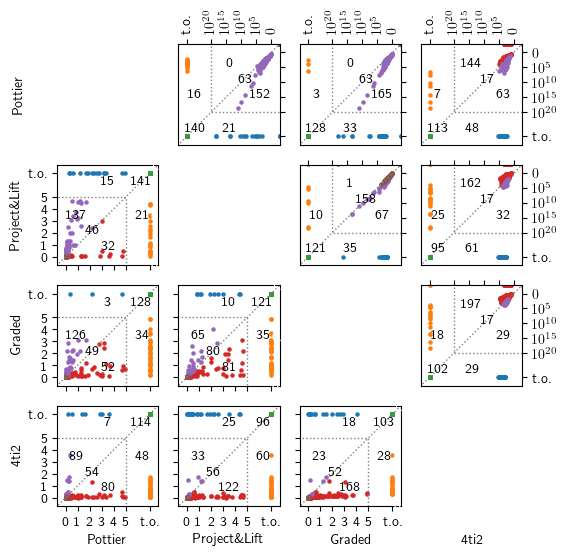

In [20]:
algos = ['Gra_pottier', 'Gra_PnL', 'Gra_degree', 'Gra_4ti2']
N = len(algos)
ticks, ticklabels, tout = [0,1,2,3,4,5,7], [0,1,2,3,4,5,'t.o.'], 7
# ticks_C, ticklabels_C, tout_C = [0,1,2,3,4,5,6,8], ['$0$', '', '$10^2$', '', '$10^4$', '', '$10^6$', 't.o.'], 8
ticks_C, ticklabels_C, tout_C = [0,5,10,15,20,28], ['$0$', '$10^5$', '$10^{10}$', '$10^{15}$', '$10^{20}$', 't.o.'], 28
fig,axes = plt.subplots(N,N, figsize=(1.5*N, 1.5*N))#, sharex=True, sharey=True)

for i in range(4):
    for j in range(4):
        if i > j:
            axes[i,j].set_xticks(ticks)
            axes[i,j].set_yticks(ticks)
            axes[i,j].set_xticklabels(ticklabels if i==N-1 else [])
            axes[i,j].set_yticklabels(ticklabels if j==0 else [])
        if i < j:
            axes[i,j].xaxis.set_ticks_position('top')
            axes[i,j].yaxis.set_ticks_position('right')
            axes[i,j].set_xticks(ticks_C)
            axes[i,j].set_yticks(ticks_C)
            axes[i,j].set_xticklabels(ticklabels_C if i==0 else [], rotation=90)
            axes[i,j].set_yticklabels(ticklabels_C if j==N-1 else [])
            axes[i,j].invert_xaxis()
            axes[i,j].invert_yaxis()

for i in range(4):
    axes[N-1,i].set_xlabel(remap(algos[i].split('_')[1]))
    axes[i, 0 ].set_ylabel(remap(algos[i].split('_')[1]))

    # axes[i,N-1].set_ylabel(remap(algos[i].split('_')[1]))
    # axes[i,N-1].yaxis.set_label_position("right")

for i in range(N):
    for j in range(N):
        ax = axes[i][j]
        if i==j:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            # Hide the ticks
            ax.tick_params(axis='x', colors='white')
            ax.tick_params(axis='y', colors='white')
        else:
            if i > j: # time
                y_tout = tout
                p1, p2 = y_tout/8, y_tout/2
                p3, p4 = ticks[-2], 0.9*y_tout
                delta = y_tout/10
                ax.set_xlim(-delta, y_tout+delta) ; ax.set_ylim(-delta, y_tout+delta)
                D = np.nan_to_num(data[[algos[i], algos[j]]].to_numpy(), nan=y_tout)
                print(algos[i], np.sum(D[:,0]==y_tout), ' ', algos[j], np.sum(D[:,1]==y_tout))
            else: # s-vector counts
                y_tout = tout_C
                p1, p2 = y_tout/8, y_tout/2
                p3, p4 = ticks_C[-2], 0.9*y_tout
                delta = y_tout/10
                ax.set_xlim(y_tout+delta, -delta) ; ax.set_ylim(y_tout+delta, -delta)
                # print(np.max(np.nan_to_num(np.log10(data[[algos[i]+'_C', algos[j]+'_C']].to_numpy()+0.001))))
                D = np.nan_to_num(np.log10(data[[algos[i]+'_C', algos[j]+'_C']].to_numpy()+0.001), nan=y_tout)

            D = D[:, [1,0]]

            f = (D[:,0] != y_tout) & (D[:,1] == y_tout)
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text(p2, p4, f'{np.sum(f)}', ha='center', va='center')

            f = (D[:,0] == y_tout) & (D[:,1] != y_tout)
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text(p4, p2, f'{np.sum(f)}', ha='center', va='center')

            f = (D[:,0] == y_tout) & (D[:,1] == y_tout)
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text(p4, p4, f'{np.sum(f)}', ha='center', va='center')

            # remove timeouts
            D = D[~(D[:,0] == y_tout) & ~(D[:,1] == y_tout)]

            f = (D[:,0] > D[:, 1]) & (D[:,1] < y_tout)
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text(p2, p1, f'{np.sum(f)}', ha='center', va='center')

            f = D[:,0] < D[:, 1]
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text(p1, p2, f'{np.sum(f)}', ha='center', va='center')

            f = D[:,0] == D[:, 1]
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text((p1+p2)/2, (p1+p2)/2, f'{np.sum(f)}', ha='center', va='center')

            ax.plot([-10,100], [-10,100], ls=':', lw=1, c='grey')
            ax.plot([-10,p3,p3], [p3,p3,-10], ls=':', lw=1, c='grey')
            
plt.savefig(f'{plot_list_name}-comparative.pdf', bbox_inches='tight')
plt.show()

In [20]:
D = data[['Gra_pottier', 'Gra_4ti2']]
D = D.dropna()
# display(D)

print(np.sum(D.Gra_pottier > D.Gra_4ti2))
print(np.sum(D.Gra_pottier < D.Gra_4ti2))


34
0


# Old code

In [ ]:
kA, kB = 'Hil_nL', 'Hil_nLH'
kAC, kBC = kA+'_C', kB+'_C'
print(f'{kB} better than {kA}:')
pd.options.display.float_format = '{:,.0f}'.format
data2 = data[(data[kAC]>=0) | (data[kBC]>=0)].copy()
data2[kAC] = data2[kAC].replace(-1, 1000000)
data2[kBC] = data2[kBC].replace(-1, 1000000)
data2[ data2[kAC] > 2*data2[kBC] + 1 ][['model', kA, kAC, kB, kBC]]

In [ ]:
print('HNF better than IGE:')
data2[ data2.Hil_IGE_C > 2*data2.Hil_HNF_C + 1 ][['model', 'Hil_HNF', 'Hil_HNF_C', 'Hil_IGE', 'Hil_IGE_C']]

In [ ]:
def make_3dplot(ax):
    ax.plot([0,2.5], [0,7.5], [0,0])
    ax.plot([0,2.5], [0,0], [0,7.5])

    ax.plot_trisurf(np.array([0, 2.5, 2.5]), 
                    np.array([0, 7.5, 0]),
                    np.array([0, 0, 7.5]), alpha=.25)
    ax.scatter3D([0], [0], [0], c='black')
    ax.scatter3D([1], [3], [0], c='r')
    ax.scatter3D([1], [0], [3], c='r')
    ax.scatter3D([1], [1], [2], c='g')
    ax.scatter3D([1], [2], [1], c='g')

    ax.scatter3D([2], [2], [4], c='b')
    ax.scatter3D([2], [4], [2], c='b')
    ax.scatter3D([2], [1], [5], c='b')
    ax.scatter3D([2], [5], [1], c='b')
    ax.scatter3D([2], [6], [0], c='b')
    ax.scatter3D([2], [0], [6], c='b')
    ax.scatter3D([2], [3], [3], c='b')

    ax.set_xlabel('$P_0$', fontsize=14)
    ax.set_ylabel('$P_1$', fontsize=14)
    ax.set_zlabel('$P_2$', fontsize=14)

    ax.set_xticks(range(3))
    ax.set_yticks(range(7))
    ax.set_zticks(range(7))

ax = plt.figure().add_subplot(projection='3d')
make_3dplot(ax)

In [ ]:
# Rotate the axes and update
for angle in tqdm(range(0, 360*4 + 1)):
    ax = plt.figure().add_subplot(projection='3d')
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

    # Cycle through a full rotation of elevation, then azimuth, roll, and all
    elev = azim = roll = 0
    if angle <= 360:
        elev = angle_norm
    elif angle <= 360*2:
        azim = angle_norm
    elif angle <= 360*3:
        roll = angle_norm
    else:
        elev = azim = roll = angle_norm

    # Update the axis view and title
    ax.view_init(elev, azim, roll)
    plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))
    make_3dplot(ax)

    # plt.draw()
    plt.savefig(f"video/image_{angle:03}.png")
    plt.close()
    # plt.pause(.001)

    # ffmpeg -framerate 24 -i video/image_%3d.png -r 10 -pix_fmt yuv420p video.mp4

In [ ]:
swaps = [(3, 0), (6, 1), (11, 2), (12, 3), (13, 4), (14, 5), (16, 6), (17, 7), (18, 8), (19, 9), 
         (20, 10), (21, 11), (22, 12), (23, 13), (24, 14), (16, 15), (22, 16), (18, 17), (20, 18), 
         (23, 19), (24, 20), (24, 21), (24, 22), (23, 23), (24, 24)]
l = list(range(25))
for a,b in swaps:
    l[a], l[b] = l[b], l[a]
print(l)

# Problem shuffle

In [506]:
with open('mats_basic/55.mat', 'r') as f:
    nr, nc = [int(x) for x in f.readline().split()]
    A = np.zeros([nr, nc], dtype=int)
    for i in range(nr):
        data = [int(x) for x in f.readline().split()]
        for j in range(nc):
            A[i,j] = data[j]
# print(nr, nc)
# print(A)

#randomly shuffle columns of A
for k in range(100):
    j1 = np.random.randint(nc)
    j2 = np.random.randint(nc)
    c1 = A[:,j1].copy()
    c2 = A[:,j2].copy()
    A[:,j1] = c2 ; A[:,j2] = c1
# print(A)

with open('mats_basic/55shuffled.mat', 'w') as f:
    print(nr,nc, file=f)
    for i in range(nr):
        for j in range(nc):
            print(A[i,j], end=' ', file=f)
        print('', file=f)
